In [1]:
import os
import IPython.display as ipd

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import utils
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.callbacks import Callback
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

2023-07-04 15:04:47.622275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 15:04:51.054672: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 15:04:54.597360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-04 15:04:54.597399: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
!pwd

/home/fll_data_bata/code/Franloplam


In [3]:
DATA_DIR = '/home/fll_data_bata/code/Franloplam/DB Gatos/dataset/dataset/'
audio_files = os.listdir(DATA_DIR)
DATA_DIR

'/home/fll_data_bata/code/Franloplam/DB Gatos/dataset/dataset/'

In [4]:
os.getcwd()

'/home/fll_data_bata/code/Franloplam'

In [5]:
# 'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'
emission_context = {'F' : [], 'I' : [], 'B' : []}

# breed (values: MC = Maine Coon; EU: European Shorthair);
sex = {'FI' : [], 'FN' : [], 'MI' : [], 'MN' : []}

for file in audio_files:
    split = file.split('_')
    if split[0] in emission_context.keys():
        emission_context.get(split[0]).append(file)
        
    if split[3] in sex.keys():
        sex.get(split[3]).append(file)

In [6]:
#emission_context

# Explore the data

## Context

### Food

In [7]:
import librosa

In [8]:
wait_food_ex = DATA_DIR + emission_context.get('F')[2]
data_food , sample_rate_F = librosa.load(wait_food_ex)
librosa.load(wait_food_ex)
#ipd.Audio(wait_food_ex)

(array([-8.0263737e-05, -3.3551996e-04, -5.8457267e-04, ...,
        -1.3037396e-04, -1.2661336e-04,  0.0000000e+00], dtype=float32),
 22050)

In [9]:
#print(data_food)
#data_food.shape

In [10]:
import matplotlib.pyplot as plt

#librosa.display.waveshow(data_food)
#plt.title("Example Sound of Waiting for Food", fontsize=20)

#plt.show()

In [11]:
X_Food = librosa.stft(data_food)
Xdb_Food = librosa.amplitude_to_db(abs(X_Food))
#librosa.display.specshow(Xdb_Food, sr=sample_rate_F, x_axis='time', y_axis='hz')
#plt.colorbar()

###  Isolated in unfamiliar Environment

In [12]:
isolated_ex = DATA_DIR+ emission_context.get('I')[0]
data_isolated , sample_rate_I  = librosa.load(isolated_ex)
#librosa.load(isolated_ex)
#ipd.Audio(isolated_ex)

In [13]:
#librosa.display.waveshow(data_isolated)
#plt.title("Example Sound of Isolated in unfamiliar Environment", fontsize = 20);

In [14]:
X_isolated = librosa.stft(data_isolated)
Xdb_isolated = librosa.amplitude_to_db(abs(X_isolated))
#librosa.display.specshow(Xdb_isolated, sr=sample_rate_I, x_axis='time', y_axis='hz')
#plt.colorbar()

### Brushing 

In [15]:
brushing_ex = DATA_DIR + emission_context.get('B')[1]
data_brushing , sample_rate_B  = librosa.load(brushing_ex)
librosa.load(brushing_ex)
#ipd.Audio(brushing_ex)

(array([ 3.1309476e-04,  3.7342482e-04,  2.8523506e-04, ...,
        -1.7574076e-04, -1.2627908e-04, -5.6869842e-05], dtype=float32),
 22050)

In [16]:
#librosa.display.waveshow(data_brushing)
#plt.title("Example Sound of Brushing", fontsize = 20);

In [17]:
X_brushing = librosa.stft(data_brushing)
Xdb_brushing = librosa.amplitude_to_db(abs(X_brushing))
#librosa.display.specshow(Xdb_brushing, sr=sample_rate_B, x_axis='time', y_axis='hz')
#plt.colorbar()

# Plot based emission context

In [18]:
len_value_emission =[]
for i in emission_context.values():
    len_value_emission.append(len(i))
len_value_emission

#F ,  I ,  B

[92, 221, 127]

In [19]:
# rename keys of dictionary
emission_context['Waiting For Food'] = emission_context.pop('F')
emission_context['Isolated in unfamiliar Environment'] = emission_context.pop('I')
emission_context['Brushing'] = emission_context.pop('B')

## Plot based sex

In [20]:
len_value_sex =[]
for i in sex.values():
    len_value_sex.append(len(i))

# rename keys of dictionary
sex['Female_intact'] = sex.pop('FI')
sex['Female_neutered'] = sex.pop('FN')
sex["Male_intact"] = sex.pop("MI")
sex["Male_neutered"] = sex.pop("MN")

#x = sex.keys()
#y = len_value_sex
#plt.bar(x, y, color ='blue')
#plt.xticks(rotation=10)
#plt.xlabel("Sex")
#plt.ylabel("Number of cat sound")

# Make all data into one dataframe

In [21]:
def add_path(list_emission):
    path = []
    for i in range(len(list_emission)):
        path.append(DATA_DIR+list_emission[i])
    return path


a = add_path(emission_context['Waiting For Food'])
b = add_path(emission_context['Isolated in unfamiliar Environment'])
c = add_path(emission_context['Brushing'])
emission = a+b+c

df = pd.DataFrame(emission, columns=['Emission'])

In [22]:
#a ---> path audios Food
#b ---> path audios Isolated
#c ---> path audios Brush

#emission ---> a+b+c

In [23]:
label_W = np.tile('Waiting For Food',92) #---> array "Waiting For Food" * 92 veces
label_I = np.tile('Isolated in unfamiliar Environment',221) #---> array "Isolated in unfamiliar Enviroment" * 221 veces
label_B = np.tile('Brushing',127) #---> array "Brushing" * 127 veces

Label = np.append(label_W, np.append(label_I, label_B))
df['Label'] = Label

In [24]:
print(df.shape)
df.sample(4)

(440, 2)


,Emission,Label
285,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment
263,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment
3,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food
32,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food


In [94]:
import librosa

def espectro_transform(audio_wav):
    audio_array = []

    for i in audio_wav:
        try:
            x, sr = librosa.load(i, sr=44100)
            audio_array.append(x)
        except (FileNotFoundError, librosa.LibrosaError):
            print(f"Error al cargar el archivo: {i}. Ignorando archivo.")

    return audio_array
    
df['Data Arrays'] = espectro_transform(df["Emission"])

In [31]:
df.sample(5)

,Emission,Label,Data Arrays
173,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[-5.3912205e-05, -5.6506782e-05, -5.361926e-05..."
402,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[6.541403e-05, 7.7679455e-05, 7.49045e-05, 5.0..."
255,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[-0.00012344713, -0.00016030113, -0.0001878278..."
153,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[-2.4888912e-05, -1.9440304e-05, -5.703776e-06..."
16,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[5.91579e-05, 8.500728e-05, 0.00010293099, 0.0..."


In [154]:
df["Data Arrays"][0].shape

(97676,)

In [155]:
df["Data Arrays"][1].shape

(59541,)

In [156]:
df["Data Arrays"][2].shape

(72881,)

# Data Augmentation

In [28]:
#!pip install audiomentations

In [32]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

#DATA_DIR_2 = '/home/fll_data_bata/code/Franloplam/DB Gatos/dataset/'

#df = pd.read_csv(DATA_DIR_2)  # Replace 'path_to_csv_file' with the actual path to your CSV file

augmenter = Compose([    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])

In [33]:
augmented_audio_list = []

In [34]:
for audio_array in df['Data Arrays']:
    augmented_audio = augmenter(samples=audio_array, sample_rate=44100)
    augmented_audio_list.append(augmented_audio)

In [35]:
df.shape

(440, 3)

In [36]:
augmented_audio_list

[array([ 0.00021097,  0.00023752,  0.00021158, ..., -0.0001334 ,
        -0.00017526, -0.00011162], dtype=float32),
 array([ 0.001277  ,  0.003088  , -0.00087873, ..., -0.00066538,
         0.00044286, -0.00041556], dtype=float32),
 array([-8.2908526e-05, -1.9362583e-04, -3.3097493e-04, ...,
         1.5946166e-04,  9.2625480e-05,  3.7616923e-05], dtype=float32),
 array([0.000768  , 0.00098627, 0.00100512, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([-1.2235214e-02, -8.0039222e-03, -1.0797200e-02, ...,
        -1.7908839e-06,  2.4321753e-06, -1.5791354e-06], dtype=float32),
 array([ 0.00499097,  0.00269454, -0.00506707, ..., -0.00346451,
         0.00112266,  0.00312531], dtype=float32),
 array([-8.3353552e-05, -1.4707274e-04, -2.2525863e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
 array([-0.00070254, -0.00078315, -0.00077602, ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 array([-0.00934559, -0.

In [37]:
df['Augmented_Data_Arrays'] = augmented_audio_list

In [38]:
df.sample(5)

,Emission,Label,Data Arrays,Augmented_Data_Arrays
153,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[-2.4888912e-05, -1.9440304e-05, -5.703776e-06...","[-1.4376246e-05, -8.610332e-06, 1.1584468e-05,..."
244,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[1.5984144e-05, -0.00012236288, -0.0003231729,...","[0.009117598, 0.0043282993, -0.009037753, -0.0..."
178,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.00044948756, 0.00048497607, 0.00046077766, ...","[-0.003561323, -0.008435549, -0.0015163491, 0...."
273,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.0002934137, 0.00038089894, 0.00044159818, 0...","[-0.0031125313, -0.017972892, 0.0012002862, -0..."
303,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.0008251318, 0.0008761408, 0.0008093907, 0.0...","[0.0039144848, -0.00583968, -0.0018816454, -0...."


In [39]:
df_augmented = pd.DataFrame({"Emission":df["Emission"],
               "Label":df["Label"],
               "Data Arrays":df["Augmented_Data_Arrays"],
               "Augmented_Data_Arrays":"Null"    
                            })

In [40]:
df_augmented.sample(5)

,Emission,Label,Data Arrays,Augmented_Data_Arrays
129,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.00024265806, 0.0004171921, 0.0037824702, 0....",Null
343,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[0.00042395576, 0.0005149867, 0.0005869714, 0....",Null
355,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[0.0021487598, -0.0012900438, 0.00039569486, 0...",Null
436,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[-0.010619342, 0.007863652, -0.01218214, 0.003...",Null
204,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[-0.018706223, 0.010459413, 0.0012683269, 0.00...",Null


In [160]:
df_augmented["Data Arrays"][0].shape

(97676,)

In [161]:
df_augmented["Data Arrays"][1].shape

(59541,)

In [162]:
df_augmented["Data Arrays"][2].shape

(72881,)

In [41]:
df_concat = pd.concat([df,df_augmented],ignore_index=True)

In [42]:
df_concat.drop("Augmented_Data_Arrays",axis=1,inplace=True)

In [43]:
df_concat

,Emission,Label,Data Arrays
0,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[0.0002239049, 0.00023594295, 0.00021665035, 0..."
1,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[-0.00069664646, -0.0008256097, -0.00088931294..."
2,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[-8.342523e-05, -0.0001941619, -0.0003314932, ..."
3,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[0.00086286897, 0.0010409814, 0.0011363981, 0...."
4,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[-0.00031048656, -0.00038651936, -0.0004299918..."
...,...,...,...
875,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[0.00011288561, 6.496918e-05, -1.901525e-05, -..."
876,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[-0.010619342, 0.007863652, -0.01218214, 0.003..."
877,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[0.0005179582, 0.0006139756, 0.0006456704, 0.0..."
878,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[0.0019407158, -0.0027761725, 0.008080474, 0.0..."


In [44]:
augmented_audio_list_2 = []

for audio_array in df_concat['Data Arrays']:
    augmented_audio = augmenter(samples=audio_array, sample_rate=44100)
    augmented_audio_list_2.append(augmented_audio)

In [45]:
len(augmented_audio_list_2)

880

In [46]:
df_concat['Augmented_Data_Arrays'] = augmented_audio_list_2

In [48]:
df_concat.sample(5)

,Emission,Label,Data Arrays,Augmented_Data_Arrays
289,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.00012831877, 0.00014669762, 0.00014566019, ...","[0.0009382345, -0.0010753274, -0.00039739945, ..."
478,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[7.922792e-05, 6.997954e-05, 5.2059066e-05, 3....","[8.665621e-05, 9.323472e-05, 7.139538e-05, 6.9..."
366,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[-0.00029861543, -0.00034772768, -0.0003699496...","[0.011691936, 0.0122347325, 0.005524034, -0.01..."
103,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[3.6816346e-09, 1.4137186e-07, 2.8485374e-07, ...","[0.009446058, 0.0060182014, -0.008716475, 0.01..."
474,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[-0.0034723403, 0.008273067, -0.029751526, 0.0...","[-0.023757018, 0.018627577, -0.03658388, 0.018..."


In [49]:
df_augmented_2 = pd.DataFrame({"Emission":df_concat["Emission"],
               "Label":df_concat["Label"],
               "Data Arrays":df_concat["Augmented_Data_Arrays"],
               "Augmented_Data_Arrays":"Null"    
                            })

In [51]:
df_augmented_2.sample(4)

,Emission,Label,Data Arrays,Augmented_Data_Arrays
223,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[-0.009725922, 0.0043277484, -0.0031538259, -0...",Null
813,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[-0.0006698904, 0.006969424, -0.0078094965, 0....",Null
174,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[3.162725e-05, 5.8577396e-05, 7.888302e-05, 7....",Null
144,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.0002753577, 0.00027501344, 0.0002283683, 0....",Null


In [52]:
df_concat_OK = pd.concat([df_concat,df_augmented_2],ignore_index=True)

In [54]:
df_concat_OK.sample(5)

,Emission,Label,Data Arrays,Augmented_Data_Arrays
672,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.005443086, 0.010518982, 0.032472987, -0.007...","[-0.0044233305, 0.02414025, 0.015359914, -0.01..."
1447,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.0072097494, -0.00551568, 0.002049116, -0.00...",Null
76,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[3.723838e-05, -0.000102597434, -0.00026516203...","[2.504384e-05, -0.00012843027, -0.0003205756, ..."
611,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[-0.0031764153, 0.0034693275, 0.0011112066, -0...","[0.015632736, 0.007991535, 0.020945627, -0.018..."
127,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Isolated in unfamiliar Environment,"[0.0001623777, 0.00025712565, 0.00036424515, 0...","[-0.012339027, 0.0028266683, -0.016884983, -0...."


In [55]:
df_concat_OK.drop("Augmented_Data_Arrays",axis=1,inplace=True)

# DATA FRAME DEFINITIVO

In [57]:
df_concat_OK

,Emission,Label,Data Arrays
0,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[0.0002239049, 0.00023594295, 0.00021665035, 0..."
1,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[-0.00069664646, -0.0008256097, -0.00088931294..."
2,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[-8.342523e-05, -0.0001941619, -0.0003314932, ..."
3,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[0.00086286897, 0.0010409814, 0.0011363981, 0...."
4,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Waiting For Food,"[-0.00031048656, -0.00038651936, -0.0004299918..."
...,...,...,...
1755,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[0.0047804974, -0.018314073, -0.00515688, 0.00..."
1756,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[-0.013197416, 0.001557344, -0.016248384, -0.0..."
1757,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[0.00047742968, 0.0006314735, 0.0006330451, 0...."
1758,/home/fll_data_bata/code/Franloplam/DB Gatos/d...,Brushing,"[0.0035234492, 0.0021412014, 0.011476568, -0.0..."


In [163]:
df_concat_OK["Data Arrays"][0].shape

(97676,)

In [164]:
df_concat_OK["Data Arrays"][1].shape

(59541,)

In [165]:
df_concat_OK["Data Arrays"][2].shape

(72881,)

# Extracting Features

## Extract

### Food 

In [58]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate_F).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate_F).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate_F).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

### Isolated 

In [59]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate_I).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate_I).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate_I).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

### Brushing

In [60]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate_B).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate_B).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate_B).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

## Get

In [61]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    #noise_data = noise(data)
    #res2 = extract_features(noise_data)
    #result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    #new_data = stretch(data)
    #data_stretch_pitch = pitch(new_data, sr=sample_rate)
    #res3 = extract_features(data_stretch_pitch)
    #result = np.vstack((result, res3)) # stacking vertically
    
    return result

# Split the data

#x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y),random_state=0, shuffle=True, test_size=0.2)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

#ORIGINAL
# making our data compatible to model.
#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

#x_train = x_train[:, np.newaxis]
#x_test = x_test[:, np.newaxis]

In [62]:
x = []
y = []
for i in range(len(df_concat_OK)):
    feature = get_features(df_concat_OK['Emission'].iloc[i])
    x.append(feature)  # Append the extracted feature array directly
    
    label = df_concat_OK['Label'].iloc[i]
    y.append(label)

#Convertir lista a np.array
x = np.vstack(x)
y = np.array(y)

le = LabelEncoder()
y = utils.to_categorical(le.fit_transform(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2)

#Agregar una dimension extra ---> 1
X_train = np.expand_dims(x_train, axis=2)
X_test = np.expand_dims(x_test, axis=2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1408, 162, 1), (1408, 3), (352, 162, 1), (352, 3))

In [168]:
x[0].shape

(162,)

In [169]:
x[1].shape

(162,)

# Baseline model 

In [63]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.05, patience=3)
model = models.Sequential()
model.add(layers.Conv1D(64, 2, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(256, 2, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(256, 2, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(1024, 2, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])

model.summary()

2023-07-04 15:23:57.577215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-04 15:23:57.585483: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-04 15:23:57.585610: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-QAN2JTD): /proc/driver/nvidia/version does not exist
2023-07-04 15:23:57.608815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 161, 64)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 161, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 160, 256)          33024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 160, 256)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 159, 256)          131328    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 159, 256)         0

In [64]:
t = time()
history = model.fit(x_train, y_train,
                    epochs=24,
                    batch_size=110,
                    validation_data=(X_test, y_test))
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/24
13/13 [==============================] - 45s 3s/step - loss: 6.3229 - accuracy: 0.4325 - val_loss: 0.9514 - val_accuracy: 0.5028
Epoch 2/24
13/13 [==============================] - 21s 2s/step - loss: 0.8897 - accuracy: 0.5732 - val_loss: 0.7994 - val_accuracy: 0.6335
Epoch 3/24
13/13 [==============================] - 20s 2s/step - loss: 0.8485 - accuracy: 0.6037 - val_loss: 0.6726 - val_accuracy: 0.6818
Epoch 4/24
13/13 [==============================] - 10s 719ms/step - loss: 0.7119 - accuracy: 0.6740 - val_loss: 0.5853 - val_accuracy: 0.7443
Epoch 5/24
13/13 [==============================] - 10s 804ms/step - loss: 0.7447 - accuracy: 0.6548 - val_loss: 0.5640 - val_accuracy: 0.7159
Epoch 6/24
13/13 [==============================] - 11s 819ms/step - loss: 0.5652 - accuracy: 0.7372 - val_loss: 0.5084 - val_accuracy: 0.7670
Epoch 7/24
13/13 [==============================] - 11s 837ms/step - loss: 0.5617 - accuracy: 0.7614 - val_loss: 0.6808 - val_accuracy: 0.6420
Epoch 8/

In [ ]:
#!pip install pyyaml h5py  # Required to save models in HDF5 format
#model.save('./model3.h5')

# Evaluation 

11/11 [==============================] - 1s 90ms/step - loss: 0.0451 - accuracy: 0.9915
Accuracy of our model on test data :  99.14772510528564 %


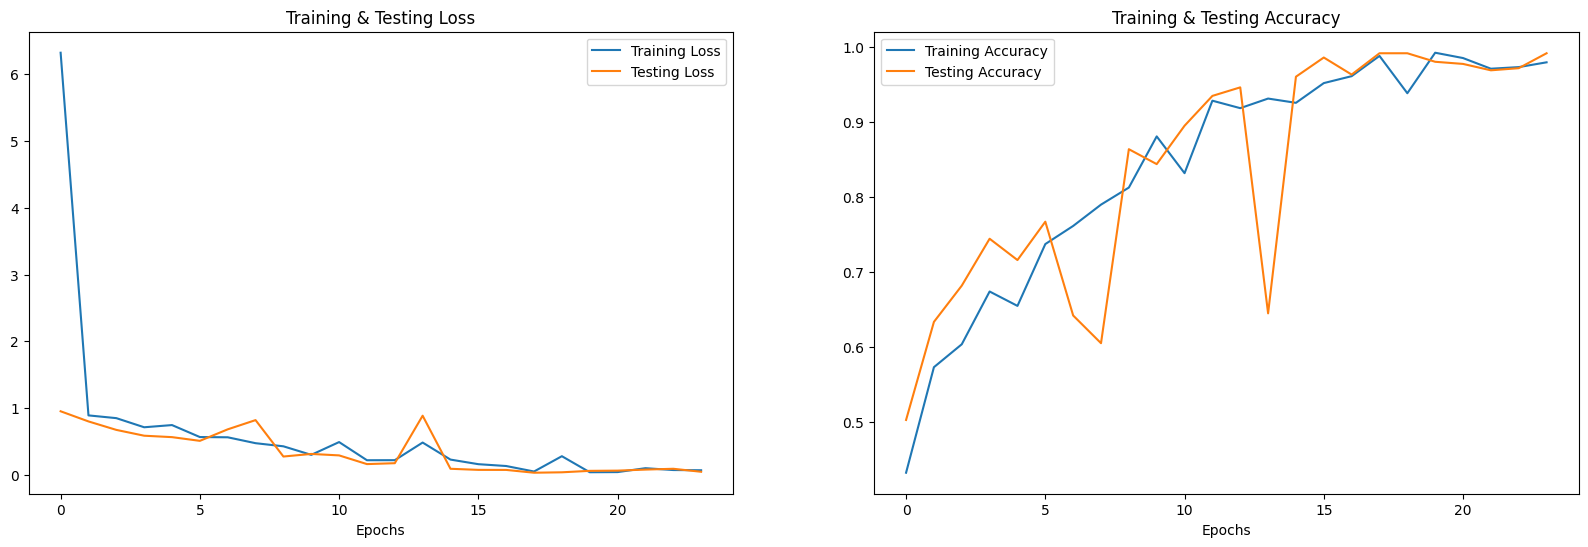

In [65]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(24)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [66]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

1408
352
1408
352


In [67]:
y_pred = model.predict(x_test)

11/11 [==============================] - 1s 87ms/step


In [68]:
y_pred

array([[4.8943464e-16, 9.9999994e-01, 4.7149721e-15],
       [9.9999827e-01, 8.9808071e-07, 7.7057581e-07],
       [0.0000000e+00, 9.9999994e-01, 0.0000000e+00],
       ...,
       [8.6608969e-05, 9.8516291e-01, 1.4750558e-02],
       [9.8485011e-01, 4.8816726e-03, 1.0268188e-02],
       [3.8957560e-06, 9.9999601e-01, 2.3239869e-08]], dtype=float32)

In [69]:
predicted_classes = np.argmax(y_pred, axis=1)

In [70]:
y_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [71]:
y_test_classes = np.argmax(y_test, axis=1)

In [72]:
y_test_classes

array([1, 0, 1, 2, 0, 0, 1, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2,
       0, 2, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 2,
       2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2,
       1, 0, 0, 2, 2, 1, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 1,
       2, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 0,
       2, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 0, 0, 0, 1,
       0, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2,
       2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 2,
       2, 1, 0, 1, 0, 0, 1, 2, 2, 2, 1, 1, 0, 1, 0,

In [73]:
predicted_classes

array([1, 0, 1, 2, 0, 0, 1, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       2, 2, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2,
       0, 2, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 2,
       2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2,
       1, 0, 0, 2, 2, 1, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 1,
       2, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 0,
       2, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1, 0, 0, 0, 0, 1,
       0, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2,
       2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 2,
       2, 1, 0, 1, 0, 0, 1, 2, 2, 2, 1, 1, 0, 1, 0,

In [74]:
por_favor_Dios_dame_un_buen_numero = 0

for i in range(len(predicted_classes)):
    if predicted_classes[i] == y_test_classes[i]:
        por_favor_Dios_dame_un_buen_numero += 1

accuracy = por_favor_Dios_dame_un_buen_numero / len(predicted_classes)
print("Accuracy:", accuracy)

Accuracy: 0.9914772727272727


In [75]:
names =['Brushing', 'Isolated in unfamiliar Environment', 'Waiting For Food']

from sklearn.metrics import classification_report
print(classification_report(y_test_classes, predicted_classes, target_names=names))

                                    precision    recall  f1-score   support

                          Brushing       0.97      1.00      0.99       103
Isolated in unfamiliar Environment       1.00      0.98      0.99       177
                  Waiting For Food       1.00      1.00      1.00        72

                          accuracy                           0.99       352
                         macro avg       0.99      0.99      0.99       352
                      weighted avg       0.99      0.99      0.99       352



-------

# Prueba 2

In [87]:
prueba_extra = "/home/fll_data_bata/code/Franloplam/DB Gatos/extras/sequences"

In [88]:
prueba_extra_path = os.listdir(prueba_extra)

In [158]:
prueba_extra_path[0]

'I_BLE01_EU_FN_DEL01_4SEQ1.wav'

In [119]:
df_prueba_extra = pd.DataFrame(columns=["Path_Prueba_Extra"])

In [120]:
df_prueba_extra["Path_Prueba_Extra"] = [os.path.join(prueba_extra,i) for i in prueba_extra_path]

In [121]:
df_prueba_extra["Path_Prueba_Extra"][25]

'/home/fll_data_bata/code/Franloplam/DB Gatos/extras/sequences/F_BRI01_MC_FI_SIM01_1SEQ1.wav'

In [122]:
df_prueba_extra['Arrays_Prueba_Extra'] = espectro_transform(df_prueba_extra["Path_Prueba_Extra"]) #transformar a espectrogramas

In [133]:
df_prueba_extra.head()

,Path_Prueba_Extra,Arrays_Prueba_Extra
0,/home/fll_data_bata/code/Franloplam/DB Gatos/e...,"[-2.8510738e-05, -1.7171827e-05, 5.451635e-06,..."
1,/home/fll_data_bata/code/Franloplam/DB Gatos/e...,"[3.711166e-05, 3.4186847e-05, 3.7627196e-05, 5..."
2,/home/fll_data_bata/code/Franloplam/DB Gatos/e...,"[-9.386457e-05, -9.0549554e-05, -5.8146456e-05..."
3,/home/fll_data_bata/code/Franloplam/DB Gatos/e...,"[-0.000979813, -0.0009797369, -0.000821513, -0..."
4,/home/fll_data_bata/code/Franloplam/DB Gatos/e...,"[-0.00059171487, -0.00074429053, -0.0008618899..."


In [147]:
df_prueba_extra["Arrays_Prueba_Extra"][0].shape

(375997,)

In [152]:
df_prueba_extra["Arrays_Prueba_Extra"][1].shape

(739028,)

In [153]:
df_prueba_extra["Arrays_Prueba_Extra"][2].shape

(542414,)

In [170]:
#Extraer features

x_prueba_extra = []

for i in range(len(df_prueba_extra)):
    feature_prueba_extra = get_features(df_prueba_extra['Path_Prueba_Extra'].iloc[i])
    x_prueba_extra.append(feature_prueba_extra)

In [175]:
len(x_prueba_extra)

30

In [176]:
#Convertir lista a np.array

x_prueba_extra = np.vstack(x_prueba_extra)

In [178]:
x_prueba_extra.shape

(30, 162)

In [179]:
#Agregar dimension

x_prueba_extra = np.expand_dims(x_prueba_extra, axis=2)

In [180]:
x_prueba_extra.shape

(30, 162, 1)

In [181]:
predict_prueba = model.predict(x_prueba_extra)

1/1 [==============================] - 15s 15s/step


In [182]:
prediction_prueba_extra = np.argmax(predict_prueba, axis=1)

In [185]:
prediction_prueba_extra

array([1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 0, 2, 1, 1, 1, 1])

In [201]:
for i in df_prueba_extra["Path_Prueba_Extra"]:
    i = i.split("/")
    print(i[-1])

I_BLE01_EU_FN_DEL01_4SEQ1.wav
I_BLE01_EU_FN_DEL01_3SEQ2.wav
F_SPI01_EU_MN_NAI01_1SEQ1.wav
B_WHO01_MC_FI_SIM01_1SEQ1.wav
F_WHO01_MC_FI_SIM01_1SEQ1.wav
I_WHO01_MC_FI_SIM01_1SEQ1.wav
I_BLE01_EU_FN_DEL01_2SEQ1.wav
I_CLE01_EU_FN_FER01_1SEQ2.wav
I_BLE01_EU_FN_DEL01_1SEQ1.wav
B_CAN01_EU_FN_GIA01_2SEQ1.wav
I_DAK01_MC_FN_SIM01_3SEQ1.wav
B_CAN01_EU_FN_GIA01_3SEQ1.wav
B_CAN01_EU_FN_GIA01_1SEQ1.wav
I_MEG01_MC_FI_SIM01_1SEQ1.wav
I_SPI01_EU_MN_NAI01_2SEQ1.wav
I_CAN01_EU_FN_GIA01_3SEQ1.wav
I_ANI01_MC_FN_SIM01_1SEQ1.wav
I_CAN01_EU_FN_GIA01_2SEQ1.wav
I_DAK01_MC_FN_SIM01_1SEQ2.wav
F_IND01_EU_FN_ELI01_1SEQ1.wav
B_CAN01_EU_FN_GIA01_2SEQ2.wav
I_BLE01_EU_FN_DEL01_2SEQ2.wav
I_CLE01_EU_FN_FER01_1SEQ1.wav
I_SPI01_EU_MN_NAI01_1SEQ1.wav
B_MIN01_EU_FN_BEN01_1SEQ1.wav
F_BRI01_MC_FI_SIM01_1SEQ1.wav
I_CAN01_EU_FN_GIA01_1SEQ1.wav
I_DAK01_MC_FN_SIM01_1SEQ1.wav
I_NUL01_MC_MI_SIM01_2SEQ1.wav
I_BLE01_EU_FN_DEL01_3SEQ1.wav


In [ ]:
#y_pred = model.predict(x_test)
#matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Waiting For Food', 'Isolated in unfamiliar Environment', 'Brushing'], yticklabels = ['Waiting For Food', 'Isolated in unfamiliar Environment', 'Brushing'])
#plt.title('Confusion Matrix', size=20)
#plt.xlabel('Predicted Labels', size=14)
#plt.ylabel('Actual Labels', size=14)
#plt.show()